In [422]:

import torch
from torch.utils.data import DataLoader
from dataset import LandsatDataLoader, LandsatSeqDataset
from model import TemporalPositionalNDVITransformer, FullyConnectedNDVIModel, LSTMNDVIModel, CNNNDVIModel
from trainer.temporal_trainer import TemporalTrainer

import logging
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import random

# set seed for all random operations
torch.manual_seed(1)
random.seed(1)



In [423]:

def load_model(checkpoint_path: str, model, num_features: int):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

In [424]:

def sample_data(val_loader: DataLoader, num_samples: int = 10) -> list:
    samples = []
    for i, data in enumerate(val_loader):
        if i >= num_samples:
            break
        samples.append(data)
    return samples


In [425]:

def temporal_seq_data_shaping(inputs, targets, device):
    x, year_seq = inputs.split(1, dim=-1)
    year_seq = year_seq.squeeze(-1)

    # move to device
    x = x.to(device)
    year_seq = year_seq.to(device)
    targets = targets.to(device)

    # we need to convert create season encoding from year_seq by
    # if year is full number (1980, 1981, 1982) - season is 0
    # if year is full number + 0.5 (1980.5, 1981.5, 1982.5) - season is 1
    seasons = torch.where(year_seq % 1 == 0, 0, 1)

    # convert year_seq to int
    year_seq_int = year_seq.int()
    return x, year_seq_int, seasons, targets

In [426]:
def create_outputs(model, samples: list) -> list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outputs_list = []

    for inputs, targets in samples:
        x, year_seq, seasons, targets = temporal_seq_data_shaping(inputs, targets, device)
        # print all the shapes in one line
        with torch.no_grad():
            # remove last dimmension of x
            x = x.squeeze(-1)
            outputs = model(x, year_seq, seasons)
            y = targets[:, 0]
            if outputs.dim() > 1 and outputs.size(1) > 1:
                outputs = outputs[:, 0]

        out_year_seq = targets[:, 1]
        outputs_list.append((x.cpu().numpy().flatten(), year_seq.cpu().numpy().flatten(), seasons.cpu().numpy().flatten(), y.cpu().numpy().flatten(), out_year_seq.cpu().numpy().flatten(), outputs.cpu().numpy().flatten()))

    return outputs_list

def evaluate_model(model, samples: list) -> None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = torch.nn.MSELoss(reduction="mean")
    mae_criterion = torch.nn.L1Loss(reduction="mean")

    outputs_list = create_outputs(model, samples)

    for i, (x, year_seq, seasons, y, out_year_seq, outputs) in enumerate(outputs_list):
        y_tensor = torch.tensor(y, device=device)
        outputs_tensor = torch.tensor(outputs, device=device)
        
        loss = criterion(y_tensor, outputs_tensor)
        mae = mae_criterion(y_tensor, outputs_tensor)

        print(f"Sample {i+1}:")
        print(f"  True Value: {y}")
        print(f"  Predicted Value: {outputs}")
        print(f"  MSE Loss: {loss.item()}")
        print(f"  MAE: {mae.item()}")
        print()

In [427]:

experiment = "best/final/transformer_seq11"

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S")

logging.info("Loading validation dataset...")
batch_size = 1
split_rate = 0.1
num_workers = 8
temporal_window = 20
dataset = LandsatSeqDataset("../data/Landsat_NDVI_time_series_1984_to_2024.tif", temporal_window)
loader = LandsatDataLoader(dataset, batch_size, split_rate, split_rate, num_workers)
_, val_loader = loader.create_data_loaders()

logging.info("Creating model...")
model = TemporalPositionalNDVITransformer(embedding_dim=256, attn_heads=8, num_encoder_layers=3, sequence_length=temporal_window, start_year=1984, end_year=2024, max_seq_length=50, num_features=1, dropout=0.0)

logging.info("Loading model...")
checkpoint_path = os.path.join("..", "runs", experiment, "checkpoint.tar")
model = load_model(checkpoint_path, model, 1)

logging.info("Sampling data...")
samples = sample_data(val_loader, 10)

2024-12-15 14:58:48 - Loading validation dataset...
2024-12-15 14:58:48 - Original NDVI data shape: (82, 1798, 1245)
2024-12-15 14:58:48 - Year information extracted: {0: 1984, 1: 1984.5, 2: 1985, 3: 1985.5, 4: 1986, 5: 1986.5, 6: 1987, 7: 1987.5, 8: 1988, 9: 1988.5, 10: 1989, 11: 1989.5, 12: 1990, 13: 1990.5, 14: 1991, 15: 1991.5, 16: 1992, 17: 1992.5, 18: 1993, 19: 1993.5, 20: 1994, 21: 1994.5, 22: 1995, 23: 1995.5, 24: 1996, 25: 1996.5, 26: 1997, 27: 1997.5, 28: 1998, 29: 1998.5, 30: 1999, 31: 1999.5, 32: 2000, 33: 2000.5, 34: 2001, 35: 2001.5, 36: 2002, 37: 2002.5, 38: 2003, 39: 2003.5, 40: 2004, 41: 2004.5, 42: 2005, 43: 2005.5, 44: 2006, 45: 2006.5, 46: 2007, 47: 2007.5, 48: 2008, 49: 2008.5, 50: 2009, 51: 2009.5, 52: 2010, 53: 2010.5, 54: 2011, 55: 2011.5, 56: 2012, 57: 2012.5, 58: 2013, 59: 2013.5, 60: 2014, 61: 2014.5, 62: 2015, 63: 2015.5, 64: 2016, 65: 2016.5, 66: 2017, 67: 2017.5, 68: 2018, 69: 2018.5, 70: 2019, 71: 2019.5, 72: 2020, 73: 2020.5, 74: 2021, 75: 2021.5, 76: 20

In [428]:
samples[0]

[tensor([[[2.9012e-01, 1.9975e+03],
          [4.2206e-01, 1.9980e+03],
          [2.0038e-01, 1.9985e+03],
          [2.3974e-01, 1.9990e+03],
          [2.3453e-01, 1.9995e+03],
          [2.4273e-01, 2.0000e+03],
          [2.9544e-01, 2.0005e+03],
          [4.1041e-01, 2.0010e+03],
          [2.2767e-01, 2.0015e+03],
          [4.7807e-01, 2.0020e+03],
          [1.3255e-01, 2.0025e+03],
          [2.8681e-01, 2.0030e+03],
          [2.4205e-01, 2.0035e+03],
          [3.3474e-01, 2.0040e+03],
          [2.1056e-01, 2.0045e+03],
          [3.5189e-01, 2.0050e+03],
          [7.7611e-02, 2.0055e+03],
          [2.2021e-01, 2.0060e+03],
          [2.3374e-01, 2.0065e+03],
          [3.1952e-01, 2.0070e+03]]]),
 tensor([[2.3931e-01, 2.0075e+03]])]

In [429]:
logging.info("Evaluating model...")
evaluate_model(model, samples)

2024-12-15 14:58:53 - Evaluating model...


Sample 1:
  True Value: [0.2393071]
  Predicted Value: [0.27584377]
  MSE Loss: 0.0013349277433007956
  MAE: 0.03653666377067566

Sample 2:
  True Value: [0.12891057]
  Predicted Value: [0.12200552]
  MSE Loss: 4.767970312968828e-05
  MAE: 0.006905049085617065

Sample 3:
  True Value: [0.22648416]
  Predicted Value: [0.3234892]
  MSE Loss: 0.009409974329173565
  MAE: 0.09700502455234528

Sample 4:
  True Value: [0.0723023]
  Predicted Value: [0.07818846]
  MSE Loss: 3.464687688392587e-05
  MAE: 0.005886159837245941

Sample 5:
  True Value: [0.31116238]
  Predicted Value: [0.1874296]
  MSE Loss: 0.015309799462556839
  MAE: 0.12373277544975281

Sample 6:
  True Value: [0.118401]
  Predicted Value: [0.09367811]
  MSE Loss: 0.0006112212431617081
  MAE: 0.024722889065742493

Sample 7:
  True Value: [0.40669814]
  Predicted Value: [0.31084538]
  MSE Loss: 0.00918775238096714
  MAE: 0.09585276246070862

Sample 8:
  True Value: [0.3220627]
  Predicted Value: [0.31639868]
  MSE Loss: 3.20811304

In [430]:
def plot_outputs(outputs_list: list, plots_per_row: int = 2) -> None:
    num_samples = len(outputs_list)
    num_rows = (num_samples + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, (x, year_seq, seasons, y, out_year_seq, outputs) in enumerate(outputs_list):
        ax = axes[i]

        # add 0.5 to year_seq if seasons is 1
        year_seq = np.where(seasons == 1, year_seq + 0.5, year_seq)
        
        # Plot input values
        ax.plot(year_seq, x, 'g.', label='Input Values')
        ax.plot(year_seq, x, 'g-')

        # Create a new line segment to connect X to Y
        # connection_x = [year_seq[-1], out_year_seq[0]]
        # connection_y = [x[-1], y[0]]
        # ax.plot(connection_x, connection_y, 'b-', linewidth=2, label='Connection')
        
        # Plot true values and predicted values
        ax.plot(out_year_seq, y, 'b.', label='True Value')
        ax.plot(out_year_seq, y, 'b-')
        ax.plot(out_year_seq, outputs, 'r.', label='Predicted Value')
        ax.plot(out_year_seq, outputs, 'r-')
        
        ax.set_xlabel('Year')
        ax.set_ylabel('NDVI')
        ax.set_ylim(0, 1)
        ax.set_title(f'Sample {i+1}')
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_predictions(model, samples: list, plots_per_row: int = 2) -> None:
    outputs_list = create_outputs(model, samples)
    plot_outputs(outputs_list, plots_per_row)

2024-12-15 14:58:53 - Plotting predictions...


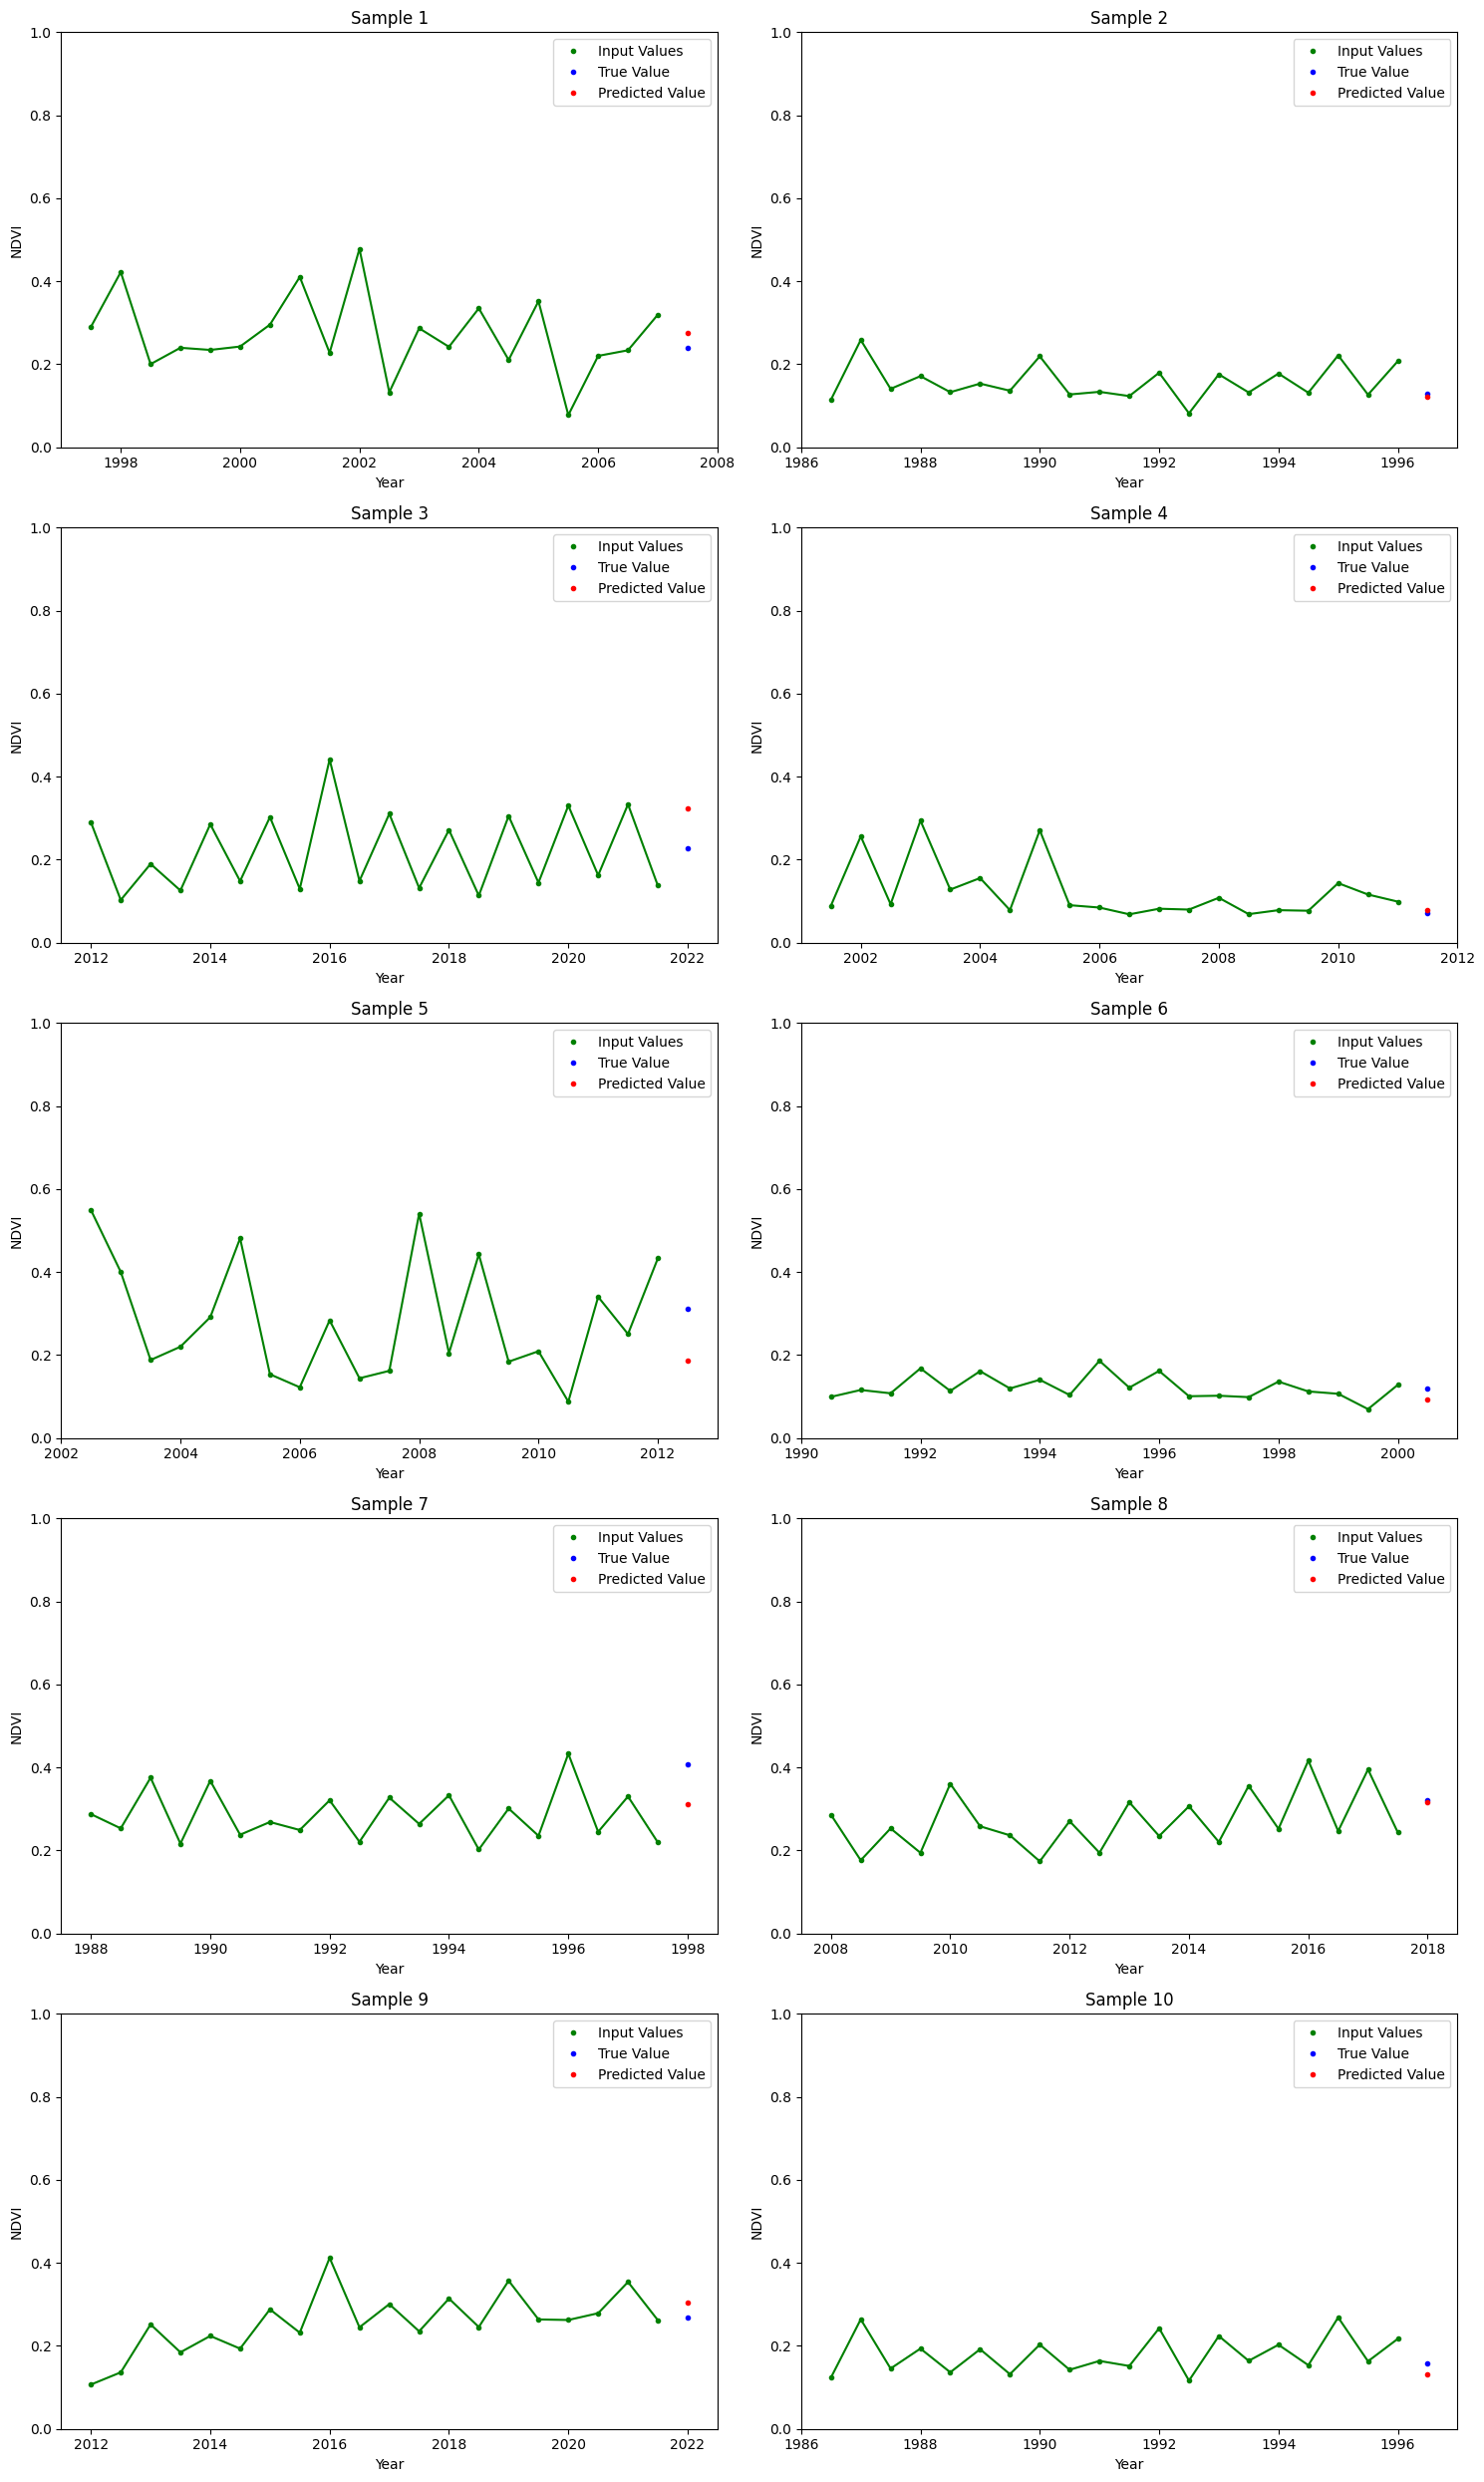

In [431]:
logging.info("Plotting predictions...")
plot_predictions(model, samples)

In [432]:
# load full data
from dataset import LandsatSpectralDataset

with rasterio.open("../data/Landsat_NDVI_time_series_1984_to_2024.tif") as src:
    ndvi_data: np.ndarray = src.read()
    band_names = src.descriptions
    logging.info(f"Original NDVI data shape: {ndvi_data.shape}")

# Extracting year information from band names
year_info = LandsatSpectralDataset.extract_year_info(band_names)
logging.info(f"Year information extracted: {year_info}")

ndvi_year_data = LandsatSpectralDataset.combine_ndvi_with_year(ndvi_data, year_info)
# restore original spatial dimensions
ndvi_year_data = ndvi_year_data.reshape(*ndvi_data.shape, 2)
logging.info(f"NDVI-Year data shape: {ndvi_year_data.shape}")

2024-12-15 14:58:55 - Original NDVI data shape: (82, 1798, 1245)
2024-12-15 14:58:55 - Year information extracted: {0: 1984, 1: 1984.5, 2: 1985, 3: 1985.5, 4: 1986, 5: 1986.5, 6: 1987, 7: 1987.5, 8: 1988, 9: 1988.5, 10: 1989, 11: 1989.5, 12: 1990, 13: 1990.5, 14: 1991, 15: 1991.5, 16: 1992, 17: 1992.5, 18: 1993, 19: 1993.5, 20: 1994, 21: 1994.5, 22: 1995, 23: 1995.5, 24: 1996, 25: 1996.5, 26: 1997, 27: 1997.5, 28: 1998, 29: 1998.5, 30: 1999, 31: 1999.5, 32: 2000, 33: 2000.5, 34: 2001, 35: 2001.5, 36: 2002, 37: 2002.5, 38: 2003, 39: 2003.5, 40: 2004, 41: 2004.5, 42: 2005, 43: 2005.5, 44: 2006, 45: 2006.5, 46: 2007, 47: 2007.5, 48: 2008, 49: 2008.5, 50: 2009, 51: 2009.5, 52: 2010, 53: 2010.5, 54: 2011, 55: 2011.5, 56: 2012, 57: 2012.5, 58: 2013, 59: 2013.5, 60: 2014, 61: 2014.5, 62: 2015, 63: 2015.5, 64: 2016, 65: 2016.5, 66: 2017, 67: 2017.5, 68: 2018, 69: 2018.5, 70: 2019, 71: 2019.5, 72: 2020, 73: 2020.5, 74: 2021, 75: 2021.5, 76: 2022, 77: 2022.5, 78: 2023, 79: 2023.5, 80: 2024, 81: 

(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)


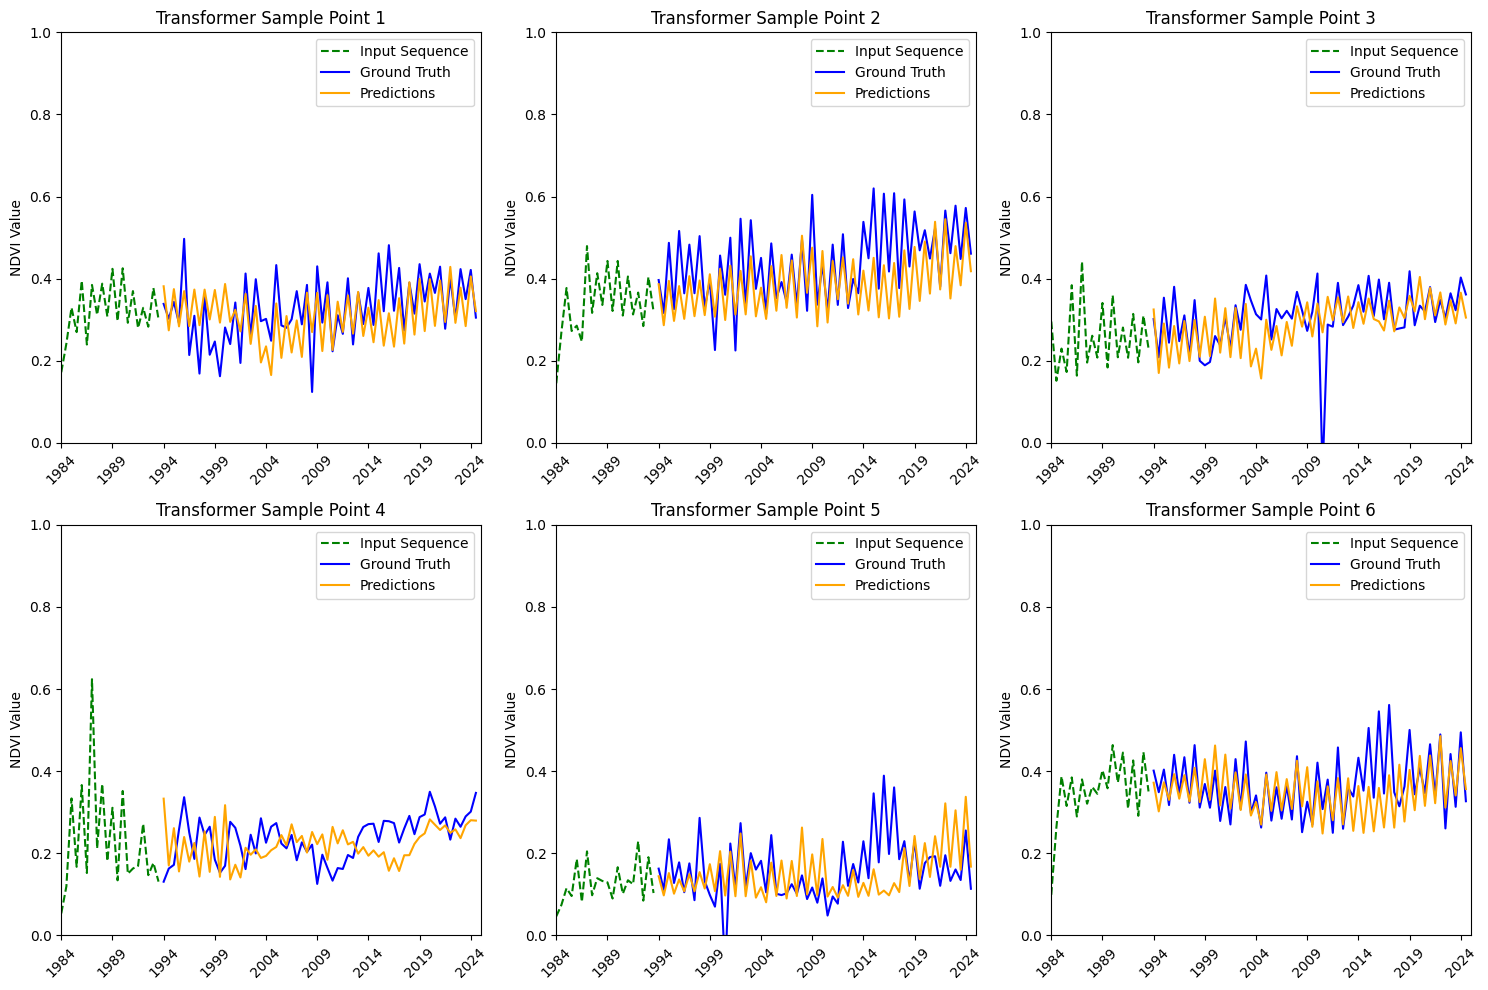

In [433]:
def sample_data(ndvi_year_data, num_samples):
    ndvi_year_data_reshaped = ndvi_year_data.reshape(ndvi_year_data.shape[0], -1, 2)
    sampled_indices = random.sample(range(ndvi_year_data_reshaped.shape[1]), num_samples)
    sampled_points = ndvi_year_data_reshaped[:, sampled_indices, :]
    return sampled_points

def generate_predictions(model, point, window_size, device):
    predictions = []
    ground_truth = []
    years = []

    for i in range(len(point) - window_size):
        input_seq = point[i:i + window_size]
        true_value = point[i + window_size, 0]  # NDVI value at the next time step
        year_value = point[i + window_size, 1]  # Year value at the next time step

        # Prepare input for the model
        x = torch.FloatTensor(input_seq[:, 0]).unsqueeze(0).unsqueeze(-1)  # NDVI values
        year_seq = torch.FloatTensor(input_seq[:, 1]).unsqueeze(0)  # Year values
        seasons = torch.where(year_seq % 1 == 0, 0, 1)

        # Move to device
        x = x.to(device)
        year_seq = year_seq.to(device)
        seasons = seasons.to(device)

        year_seq_int = year_seq.int()

        # Get model prediction
        with torch.no_grad():
            x = x.squeeze(-1)
            predicted_value = model(x, year_seq_int, seasons).cpu().numpy().flatten()[0]

        # Store predictions, ground truth, and years
        predictions.append(predicted_value)
        ground_truth.append(true_value)
        years.append(year_value)

    return predictions, ground_truth, years

def visualize_predictions(predictions_list, ground_truth_list, years_list, input_sequences_list, graphs_per_row, title_prefix):
    num_samples = len(predictions_list)
    num_rows = (num_samples + graphs_per_row - 1) // graphs_per_row  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows), sharex=False)  # Allow independent X-axis values
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, (predictions, ground_truth, years, input_seq) in enumerate(
        zip(predictions_list, ground_truth_list, years_list, input_sequences_list)
    ):
        axes[idx].plot(
            input_seq[:, 1], input_seq[:, 0], label='Input Sequence', color='green', linestyle='--'
        )  # Input Sequence visualization
        axes[idx].set_ylabel('NDVI Value')
        axes[idx].plot(years, ground_truth, label='Ground Truth', color='blue')
        axes[idx].plot(years, predictions, label='Predictions', color='orange')
        axes[idx].set_title(f'{title_prefix} Sample Point {idx + 1}')
        axes[idx].legend()
        axes[idx].set_ylim(0, 1)  # Set y-axis scale to 0..1
        axes[idx].set_xlim(1984, 2025)  # Set the X-axis limits
        axes[idx].set_xticks(range(1984, 2026, 5))  # Set X-axis ticks every 5 years
        axes[idx].tick_params(axis='x', rotation=45)  # Rotate X-axis labels for better readability

    for ax in axes[num_samples:]:  # Hide any unused subplots
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Sample 6 points based on spatial dimension 1:2
num_samples = 6
sampled_points = sample_data(ndvi_year_data, num_samples)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store predictions, ground truth, and years for all sampled points
predictions_list = []
ground_truth_list = []
years_list = []
input_sequences_list = []

# Iterate over each sampled point
for idx, point in enumerate(sampled_points.transpose(1, 0, 2)):
    print(point.shape)
    predictions, ground_truth, years = generate_predictions(model, point, temporal_window, device)
    input_sequences_list.append(point[:temporal_window])  # Store the input sequences (NDVI + years)
    predictions_list.append(predictions)
    ground_truth_list.append(ground_truth)
    years_list.append(years)

# Visualize all sampled points on the same image split into 5 graphs
graphs_per_row = 3  # Control how many graphs per row
visualize_predictions(predictions_list, ground_truth_list, years_list, input_sequences_list, graphs_per_row, "Transformer")

In [434]:
import torch
from sklearn.metrics import r2_score
from tqdm import tqdm
import numpy as np

def evaluate_model_on_sample(model, val_loader, device, sample_fraction):
    model.eval()
    criterion_mse = torch.nn.MSELoss(reduction="mean")
    criterion_mae = torch.nn.L1Loss(reduction="mean")

    total_samples = len(val_loader.dataset)
    sample_size = int(total_samples * sample_fraction)
    sampled_indices = torch.randperm(total_samples)[:sample_size]

    mse_losses = []
    mae_losses = []
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for idx in tqdm(sampled_indices, desc="Evaluating", unit="sample"):
            inputs, targets = val_loader.dataset[idx]
            inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)  # Add batch dimension
            
            x, year_seq, seasons, targets = temporal_seq_data_shaping(inputs, targets, device)
            x = x.squeeze(-1)
            outputs = model(x, year_seq, seasons)
            y = targets[:, 0]
            if outputs.dim() > 1 and outputs.size(1) > 1:
                outputs = outputs[:, 0]
            mse_loss = criterion_mse(y, outputs).item()
            mae_loss = criterion_mae(y, outputs).item()
            
            # Ensure dimensions are compatible for concatenation
            all_targets.append(np.atleast_1d(y.cpu().numpy()))
            all_outputs.append(np.atleast_1d(outputs.cpu().numpy()))

            mse_losses.append(mse_loss)
            mae_losses.append(mae_loss)

    avg_mse_loss = sum(mse_losses) / len(mse_losses)
    avg_mae_loss = sum(mae_losses) / len(mae_losses)
    
    # Flatten the lists of arrays
    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs)
    
    # Calculate R² score globally
    avg_r2_score = r2_score(all_targets, all_outputs)

    print(f"Evaluation on {sample_fraction*100}% of validation dataset:")
    print(f"  Mean Squared Error (MSE): {avg_mse_loss}")
    print(f"  Mean Absolute Error (MAE): {avg_mae_loss}")
    print(f"  R2 Score: {avg_r2_score}")

# Evaluate the model on 1% of the validation dataset
#evaluate_model_on_sample(model, val_loader, device, sample_fraction=0.1)


# Visualize Ground Truth

(82, 100, 70)
(100, 70)
(100, 70)
(100, 70)
(100, 70)
(100, 70)
(100, 70)


<Figure size 1500x1000 with 0 Axes>

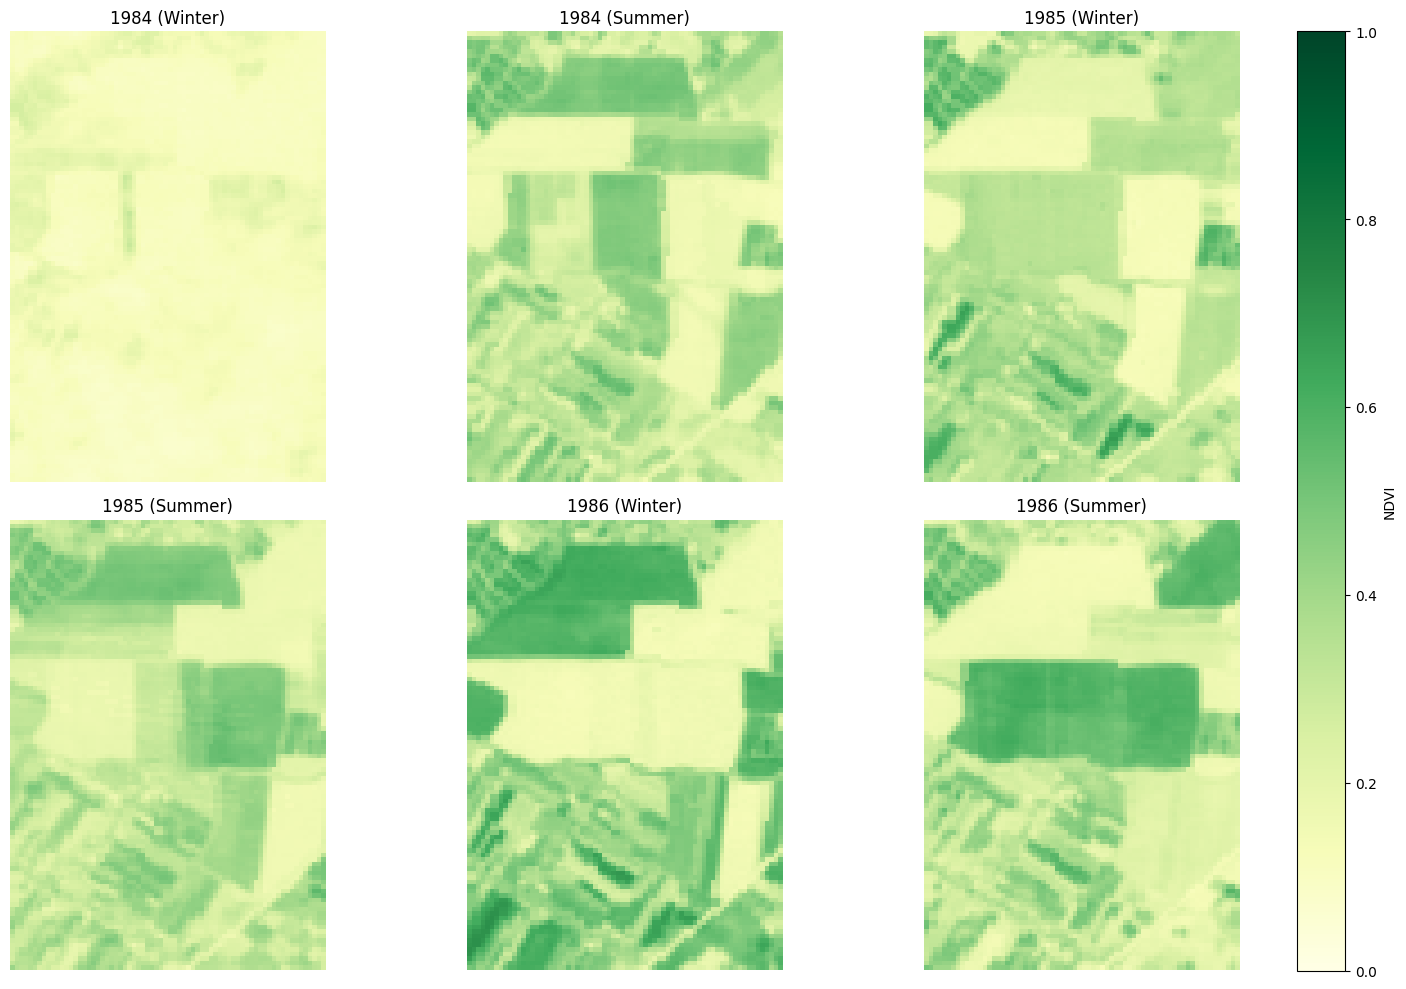

In [435]:
# visualize the ground truth at position 100x100, in size of 50 pixels to each side
# Define the center point and window size
center_x: int = 100
center_y: int = 100
window_size_ground_truth = 50

# Calculate window boundaries
x_start: int = max(0, center_x - window_size_ground_truth)
x_end: int = min(ndvi_data.shape[1], center_x + window_size_ground_truth)
y_start: int = max(0, center_y - window_size_ground_truth)
y_end: int = min(ndvi_data.shape[2], center_y + temporal_window)

# Extract the window of data
window_data = ndvi_data[:, x_start:x_end, y_start:y_end]
print(window_data.shape)

# Create a figure with subplots for different time points
plt.figure(figsize=(15, 10))

# Plot 6 consecutive time points
time_points = np.arange(6, dtype=int)

# Create figure with a single colorbar on the right
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.1])

# Dictionary to map index to year and season
def get_year_season(idx):
    year = 1984 + idx // 2
    season = "Summer" if idx % 2 else "Winter"
    return f"{year} ({season})"

for i, t in enumerate(time_points):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    print(window_data[t].shape)
    im = ax.imshow(window_data[t], cmap='YlGn', vmin=0, vmax=1)
    ax.set_title(get_year_season(t))
    ax.axis('off')

# Add a single colorbar on the right
cax = fig.add_subplot(gs[:, -1])
plt.colorbar(im, cax=cax, label='NDVI')

plt.tight_layout()
plt.show()


# Visualize Predictions

In [436]:
# Extract data around point (100,100) with window size 20
center_x = 100
center_y = 100
spatial_window_size_prediction = 20

# num_samples = 6
# sampled_points_random = sample_data(ndvi_year_data, num_samples)
# print(sampled_points_random.shape)

# Calculate window boundaries
x_start = max(0, center_x - spatial_window_size_prediction)
x_end = min(ndvi_year_data.shape[1], center_x + spatial_window_size_prediction)
y_start = max(0, center_y - spatial_window_size_prediction)
y_end = min(ndvi_year_data.shape[2], center_y + spatial_window_size_prediction)

# Extract the window of data and reshape to (num_pixels, timesteps, features)
sampled_points = ndvi_year_data[:, x_start:x_end, y_start:y_end].reshape(-1, ndvi_year_data.shape[0], 2)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store predictions, ground truth, and years for all sampled points
predictions_list = []
ground_truth_list = []
years_list = []
input_sequences_list = []

print(sampled_points.shape)

# Iterate over each sampled point
for idx, point in enumerate(sampled_points):
    predictions, ground_truth, years = generate_predictions(model, point, temporal_window, device)
    input_sequences_list.append(point[:temporal_window])  # Store the input sequences (NDVI + years)
    predictions_list.append(predictions)
    ground_truth_list.append(ground_truth)
    years_list.append(years)


(1600, 82, 2)


(1600, 62)


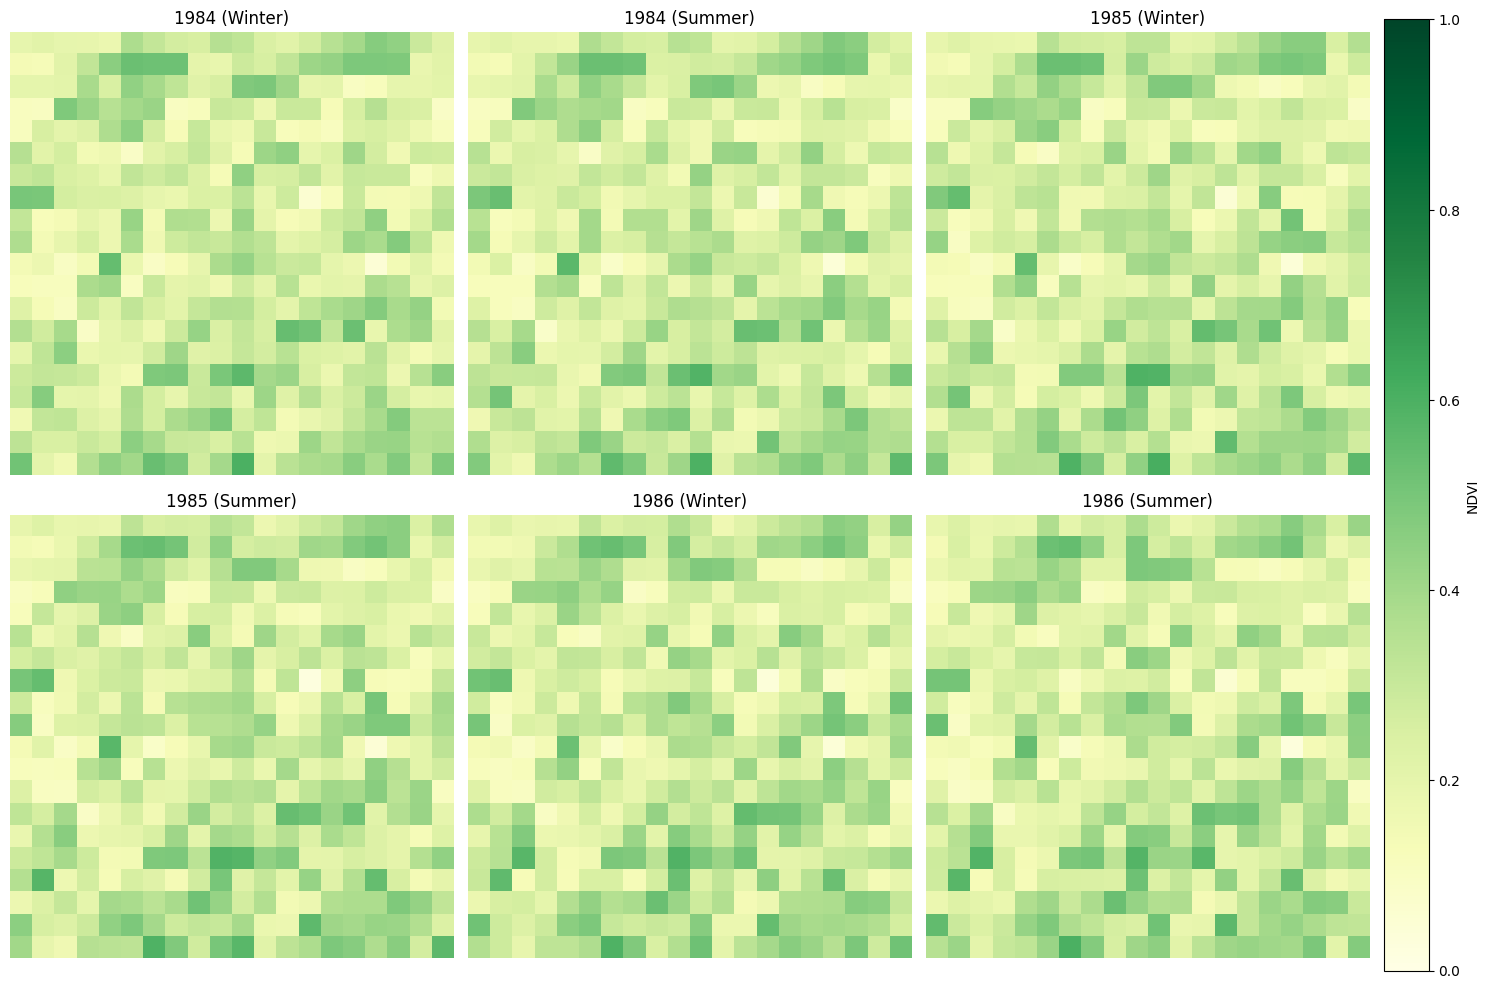

In [437]:
# convert predictions_list, ground_truth_list, years_list, input_sequences_list to numpy arrays
predictions_list_numpy = np.array(predictions_list)
print(predictions_list_numpy.shape)

# take only the first value of last axis, and convert into box in shape of spatial_window_size_prediction*spatial_window_size_prediction
predictions_list_box = predictions_list_numpy.reshape(spatial_window_size_prediction, spatial_window_size_prediction, -1).transpose(2, 0, 1)


# Plot 6 consecutive time points
time_points = np.arange(6, dtype=int)

# Create figure with a single colorbar on the right
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.1])

# Dictionary to map index to year and season
def get_year_season(idx):
    year = 1984 + idx // 2
    season = "Summer" if idx % 2 else "Winter"
    return f"{year} ({season})"

for i, t in enumerate(time_points):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    im = ax.imshow(predictions_list_box[t], cmap='YlGn', vmin=0, vmax=1)
    ax.set_title(get_year_season(t))
    ax.axis('off')

# Add a single colorbar on the right
cax = fig.add_subplot(gs[:, -1])
plt.colorbar(im, cax=cax, label='NDVI')

plt.tight_layout()
plt.show()


# Other Models

In [438]:
logging.info("Creating fully connected model...")
model_fully_connected = FullyConnectedNDVIModel(sequence_length=11, hidden_size=64, num_layers=3)

logging.info("Loading fully connected model...")
checkpoint_path = os.path.join("..", "runs", "fc_seq11_layers3", "checkpoint.tar")
model_fully_connected = load_model(checkpoint_path, model_fully_connected, 1)

2024-12-15 15:01:35 - Creating fully connected model...
2024-12-15 15:01:35 - Loading fully connected model...
/tmp/ipykernel_22806/3017543190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

In [439]:
logging.info("Creating transformer model...")
model_transformer = TemporalPositionalNDVITransformer(embedding_dim=256, attn_heads=8, num_encoder_layers=3, sequence_length=11, start_year=1984, end_year=2024, max_seq_length=50, num_features=1, dropout=0.0)

logging.info("Loading transformer model...")
checkpoint_path = os.path.join("..", "runs", "transformer_seq11", "checkpoint.tar")
model_transformer = load_model(checkpoint_path, model_transformer, 1)

2024-12-15 15:01:35 - Creating transformer model...
2024-12-15 15:01:35 - Loading transformer model...
/tmp/ipykernel_22806/3017543190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

In [440]:
logging.info("Creating LSTM model...")
model_lstm = LSTMNDVIModel(sequence_length=11, hidden_size=64, num_layers=3)

logging.info("Loading LSTM model...")
checkpoint_path = os.path.join("..", "runs", "lstm_seq11_layers3", "checkpoint.tar")
model_lstm = load_model(checkpoint_path, model_lstm, 1)

2024-12-15 15:01:35 - Creating LSTM model...
2024-12-15 15:01:35 - Loading LSTM model...
/tmp/ipykernel_22806/3017543190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

In [441]:

logging.info("Creating CNN model...")
model_cnn = CNNNDVIModel(sequence_length=11, num_channels=64, kernel_size=3, num_layers=3)

logging.info("Loading CNN model...")
checkpoint_path = os.path.join("..", "runs", "cnn_seq11_layers3", "checkpoint.tar")
model_cnn = load_model(checkpoint_path, model_cnn, 1)

2024-12-15 15:01:35 - Creating CNN model...
2024-12-15 15:01:35 - Loading CNN model...
/tmp/ipykernel_22806/3017543190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch

(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)


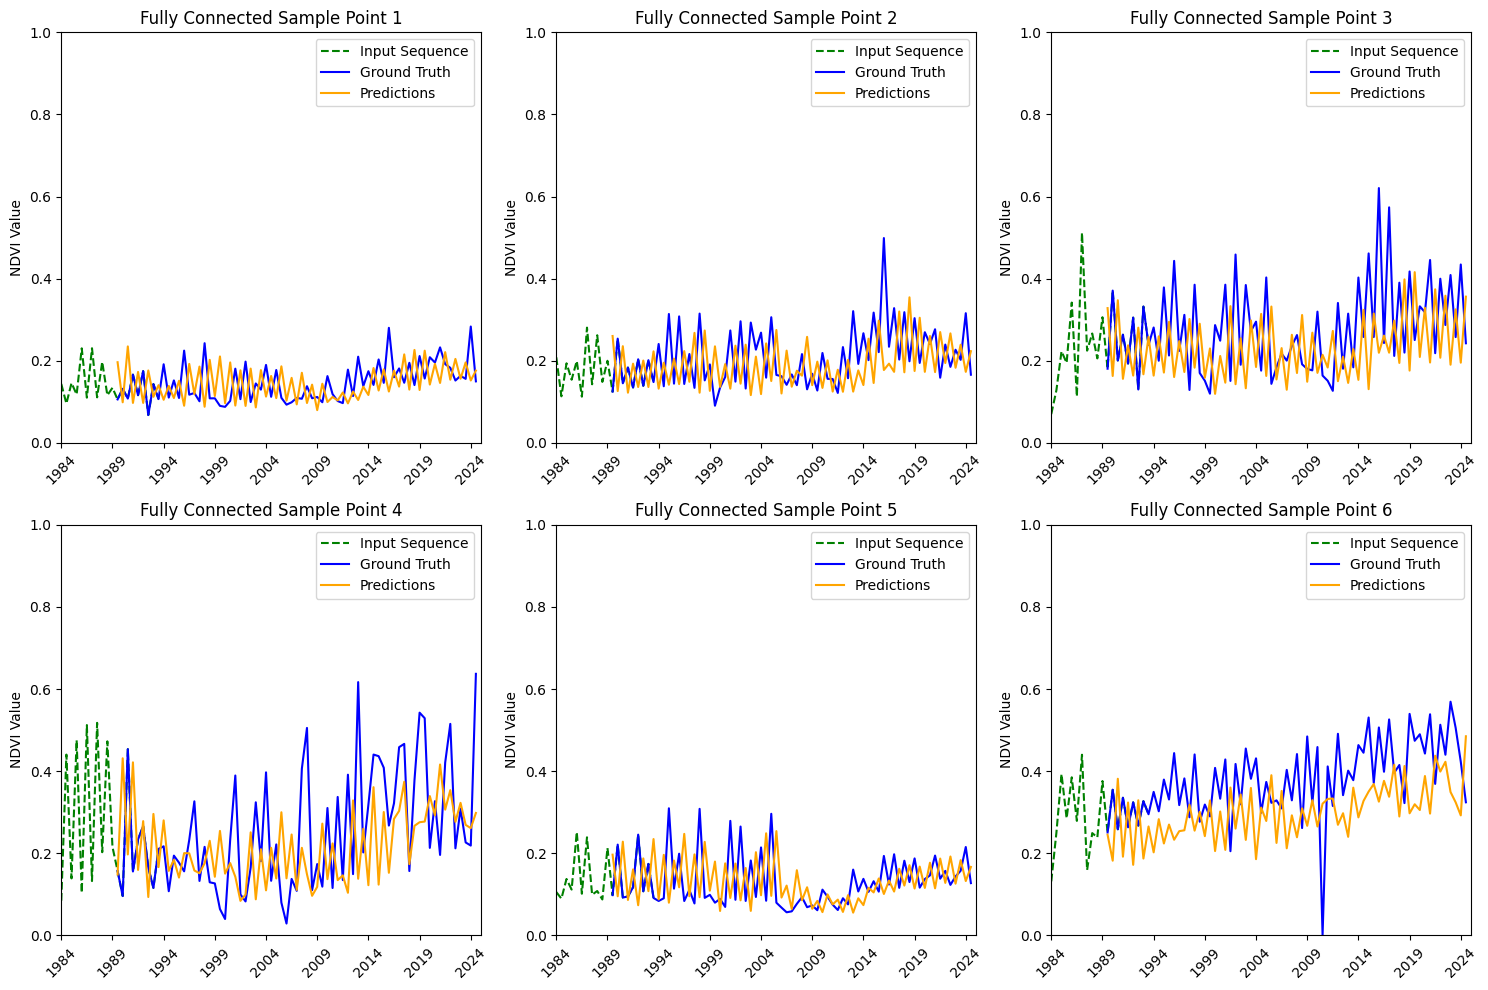

(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)


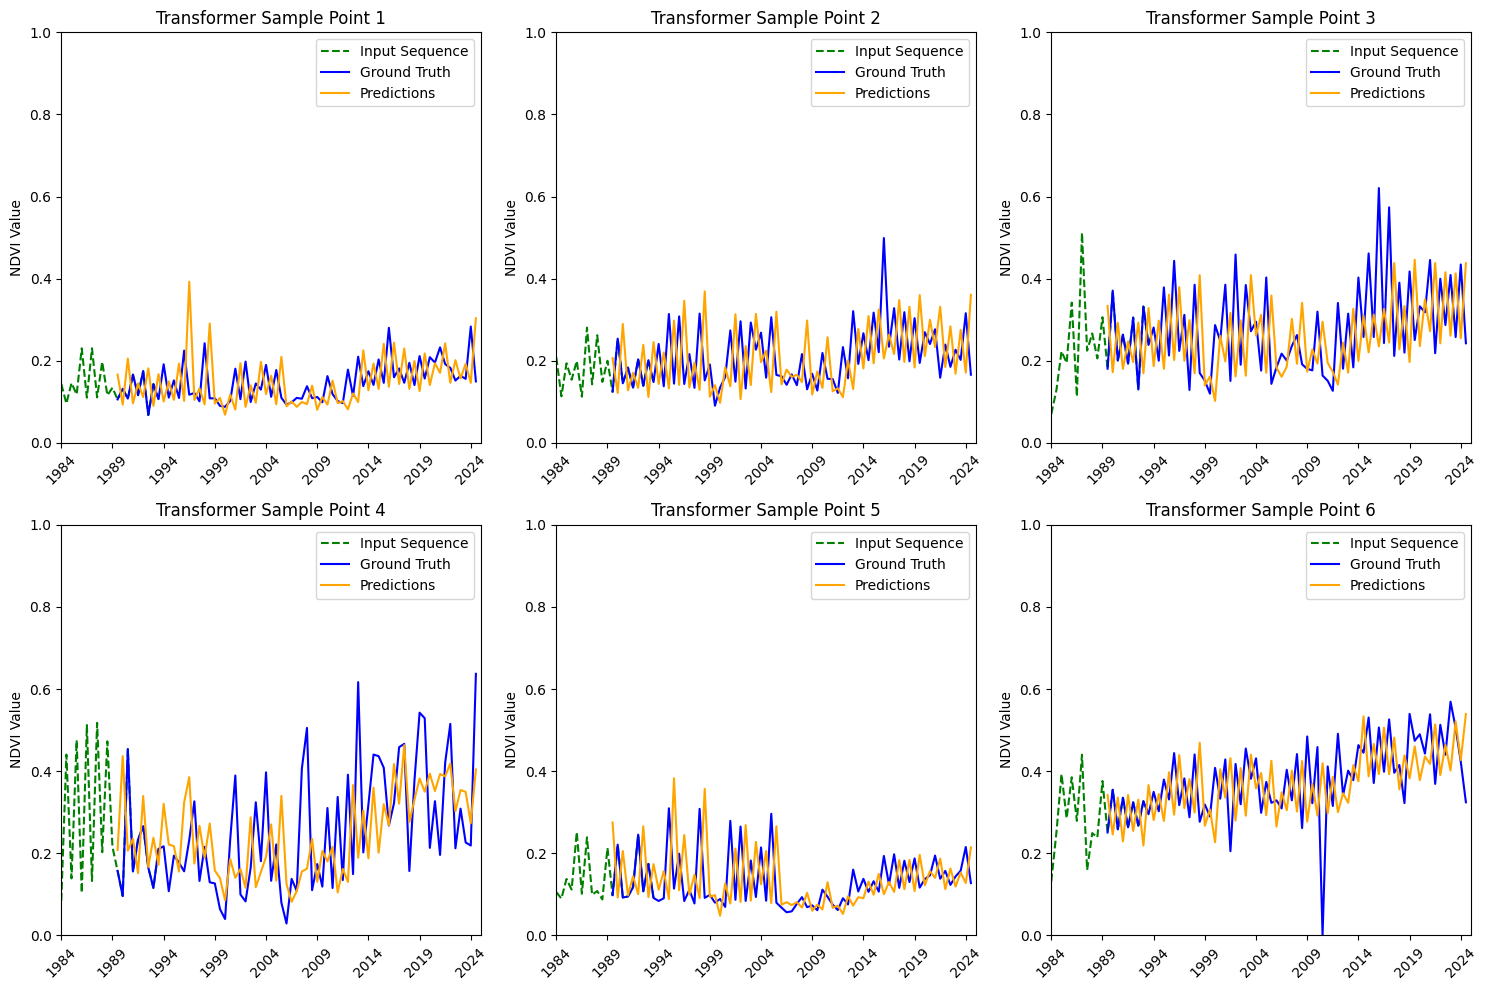

(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)


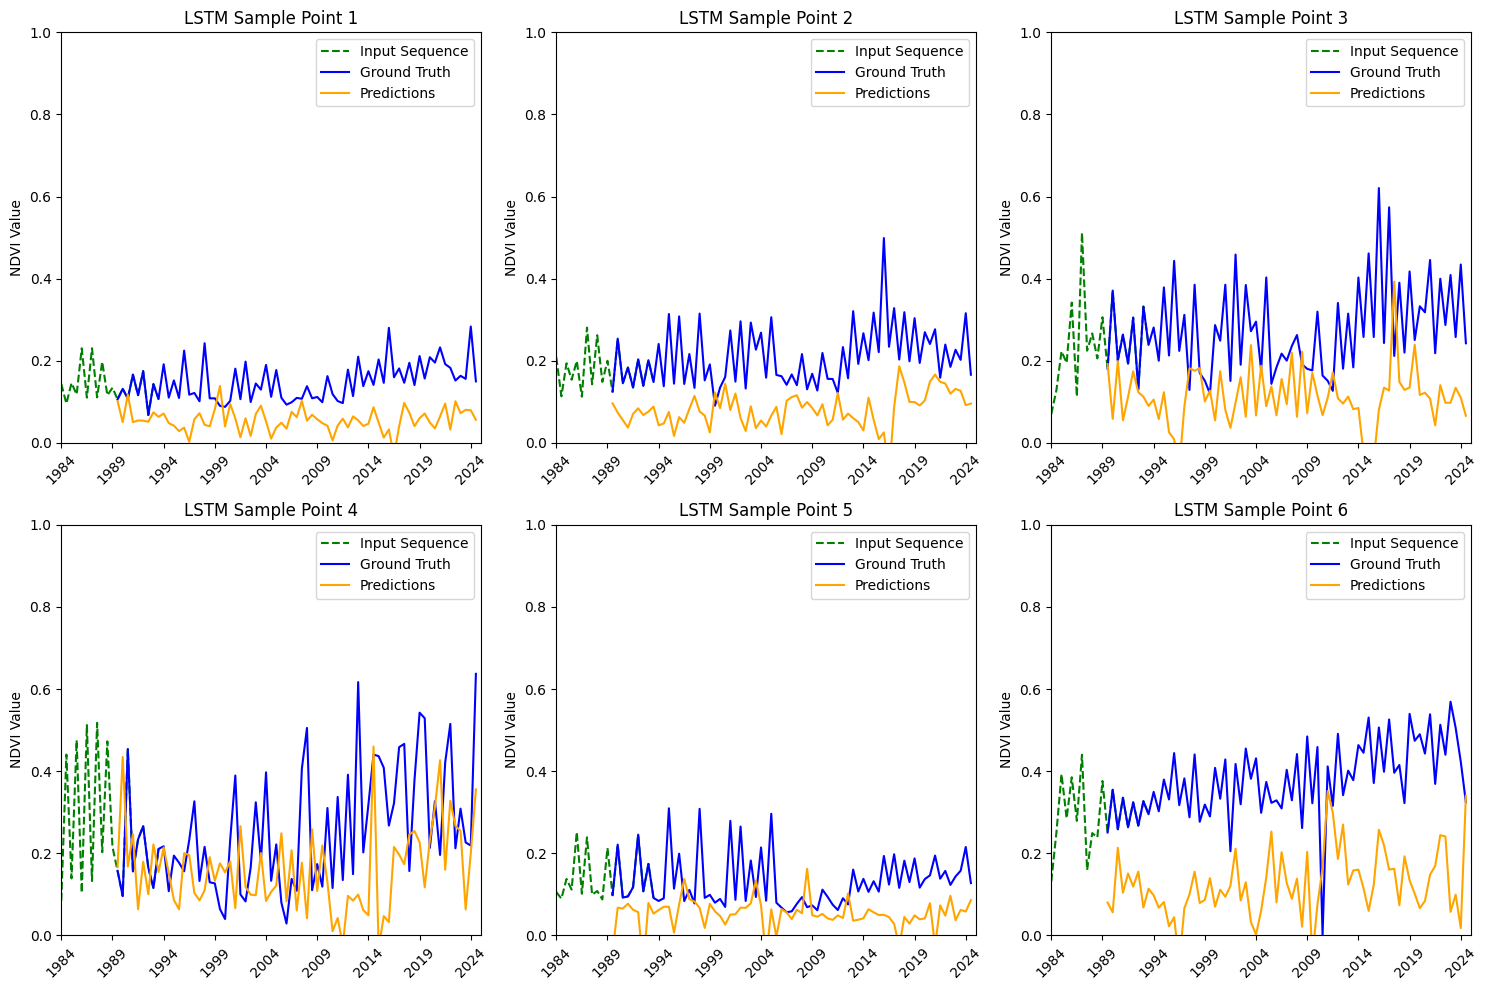

(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)
(82, 2)


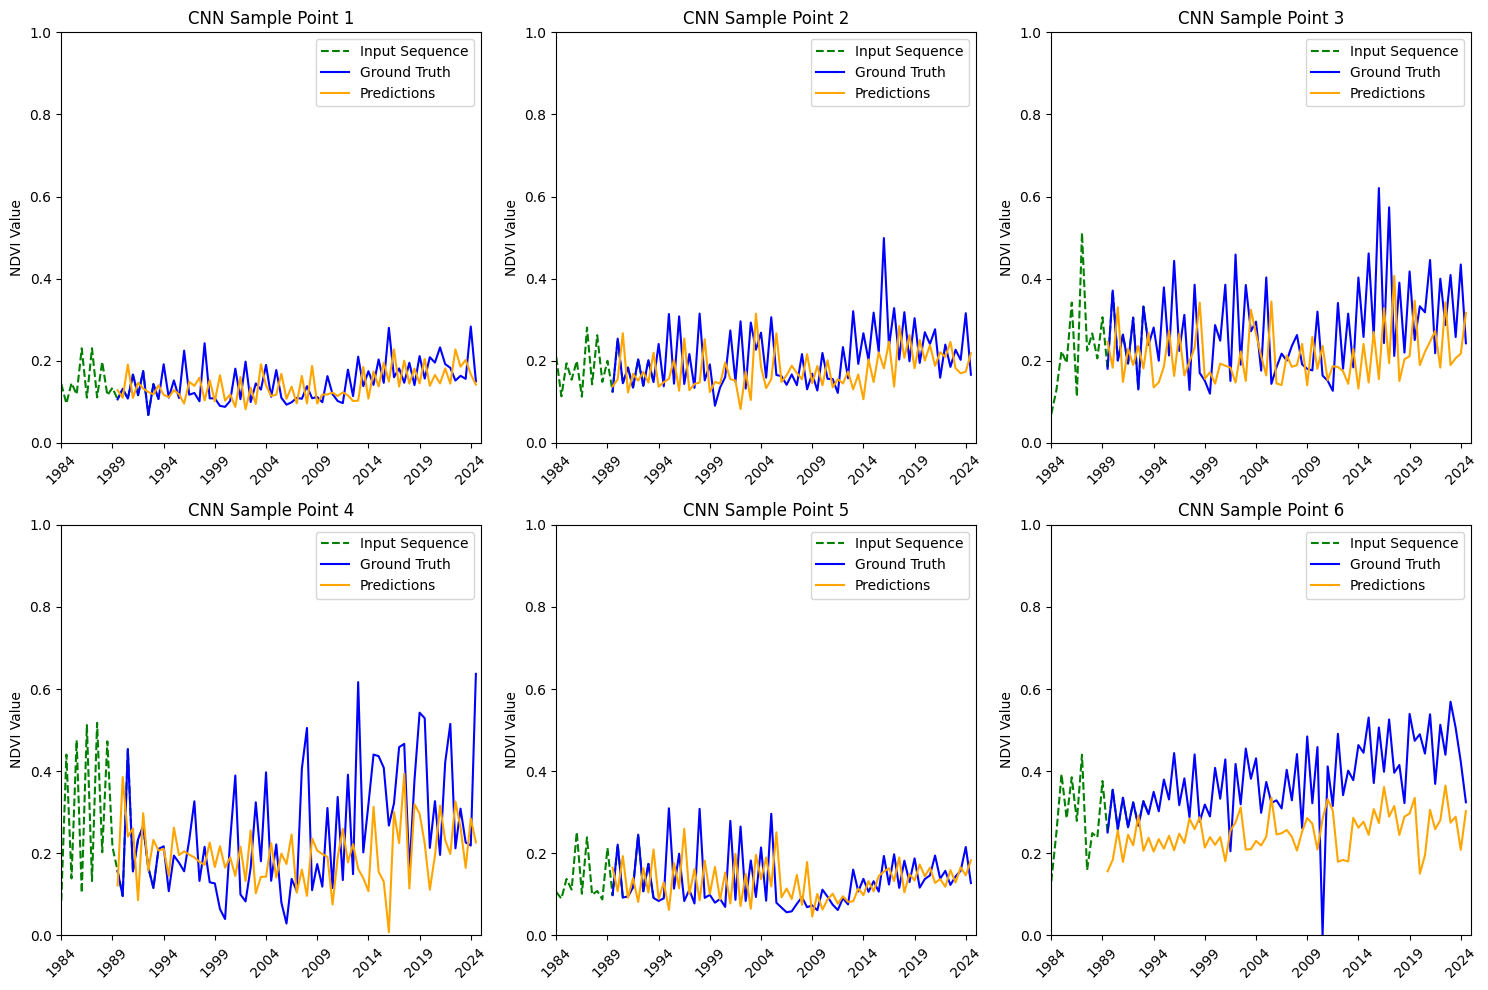

In [442]:
# Sample 6 points based on spatial dimension 1:2
num_samples = 6
sampled_points = sample_data(ndvi_year_data, num_samples)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store predictions, ground truth, and years for all sampled points
predictions_list_fully_connected = []
ground_truth_list_fully_connected = []
years_list_fully_connected = []
input_sequences_list_fully_connected = []

# Iterate over each sampled point
for idx, point in enumerate(sampled_points.transpose(1, 0, 2)):
    print(point.shape)
    predictions, ground_truth, years = generate_predictions(model_fully_connected, point, 11, device)
    input_sequences_list_fully_connected.append(point[:temporal_window])  # Store the input sequences (NDVI + years)
    predictions_list_fully_connected.append(predictions)
    ground_truth_list_fully_connected.append(ground_truth)
    years_list_fully_connected.append(years)

# Visualize all sampled points on the same image split into 5 graphs
graphs_per_row = 3  # Control how many graphs per row
visualize_predictions(predictions_list_fully_connected, ground_truth_list_fully_connected, years_list_fully_connected, input_sequences_list_fully_connected, graphs_per_row, "Fully Connected")

# Transformer
predictions_list_transformer = []
ground_truth_list_transformer = []
years_list_transformer = []
input_sequences_list_transformer = []

for idx, point in enumerate(sampled_points.transpose(1, 0, 2)):
    print(point.shape)
    predictions, ground_truth, years = generate_predictions(model_transformer, point, 11, device)
    input_sequences_list_transformer.append(point[:temporal_window])  # Store the input sequences (NDVI + years)
    predictions_list_transformer.append(predictions)
    ground_truth_list_transformer.append(ground_truth)
    years_list_transformer.append(years)

# Visualize all sampled points on the same image split into 5 graphs
graphs_per_row = 3  # Control how many graphs per row
visualize_predictions(predictions_list_transformer, ground_truth_list_transformer, years_list_transformer, input_sequences_list_transformer, graphs_per_row, "Transformer")

# LSTM
predictions_list_lstm = []
ground_truth_list_lstm = []
years_list_lstm = []
input_sequences_list_lstm = []

for idx, point in enumerate(sampled_points.transpose(1, 0, 2)):
    print(point.shape)
    predictions, ground_truth, years = generate_predictions(model_lstm, point, 11, device)
    input_sequences_list_lstm.append(point[:temporal_window])  # Store the input sequences (NDVI + years)
    predictions_list_lstm.append(predictions)
    ground_truth_list_lstm.append(ground_truth)
    years_list_lstm.append(years)

# Visualize all sampled points on the same image split into 5 graphs
graphs_per_row = 3  # Control how many graphs per row
visualize_predictions(predictions_list_lstm, ground_truth_list_lstm, years_list_lstm, input_sequences_list_lstm, graphs_per_row, "LSTM")

# CNN
predictions_list_cnn = []
ground_truth_list_cnn = []
years_list_cnn = []
input_sequences_list_cnn = []

for idx, point in enumerate(sampled_points.transpose(1, 0, 2)):
    print(point.shape)
    predictions, ground_truth, years = generate_predictions(model_cnn, point, 11, device)
    input_sequences_list_cnn.append(point[:temporal_window])  # Store the input sequences (NDVI + years)
    predictions_list_cnn.append(predictions)
    ground_truth_list_cnn.append(ground_truth)
    years_list_cnn.append(years)

# Visualize all sampled points on the same image split into 5 graphs
graphs_per_row = 3  # Control how many graphs per row
visualize_predictions(predictions_list_cnn, ground_truth_list_cnn, years_list_cnn, input_sequences_list_cnn, graphs_per_row, "CNN")


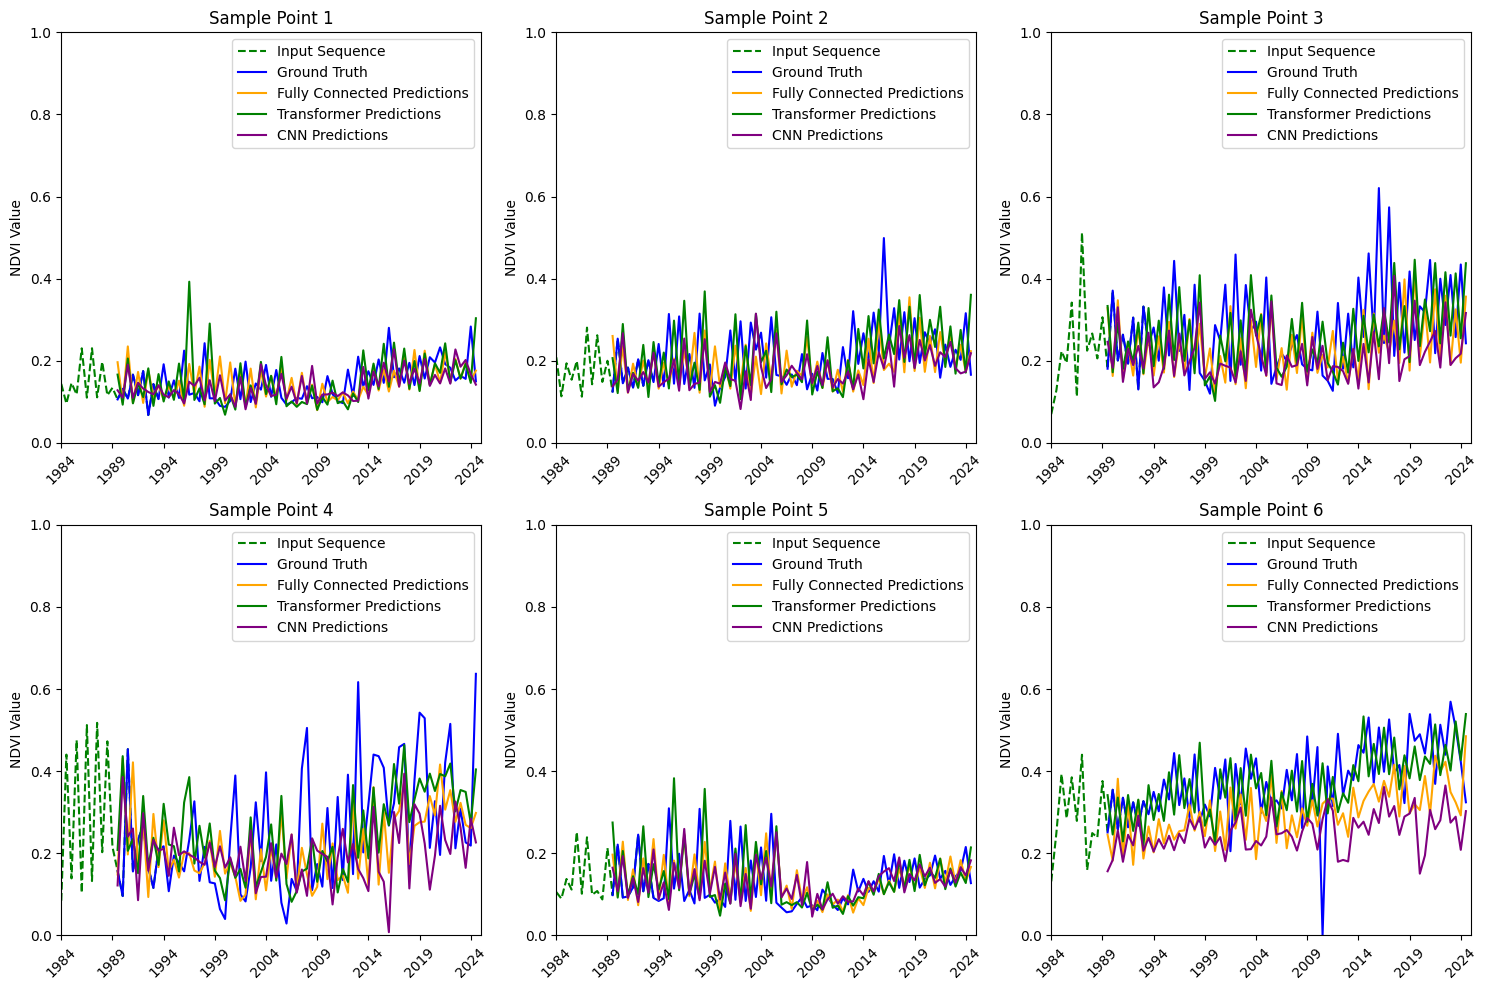

In [443]:
# Create a figure with subplots
num_points = 6
num_rows = (num_points + 2) // 3  # Round up division
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 10))
axes = axes.flatten()


# Plot each point's predictions
for i in range(num_points):
    plt.sca(axes[i])
    axes[i].plot(
        input_sequences_list_fully_connected[i][:, 1], input_sequences_list_fully_connected[i][:, 0], 
        label='Input Sequence', color='green', linestyle='--'
    )  # Input Sequence visualization
    axes[i].set_ylabel('NDVI Value')
    axes[i].plot(years_list_fully_connected[i], ground_truth_list_fully_connected[i], label='Ground Truth', color='blue')
    axes[i].plot(years_list_fully_connected[i], predictions_list_fully_connected[i], label='Fully Connected Predictions', color='orange')
    axes[i].plot(years_list_transformer[i], predictions_list_transformer[i], label='Transformer Predictions', color='green')
    #axes[i].plot(years_list_lstm[i], predictions_list_lstm[i], label='LSTM Predictions', color='red')
    axes[i].plot(years_list_cnn[i], predictions_list_cnn[i], label='CNN Predictions', color='purple')
    axes[i].set_title(f'Sample Point {i + 1}')
    axes[i].legend()
    axes[i].set_ylim(0, 1)  # Set y-axis scale to 0..1
    axes[i].set_xlim(1984, 2025)  # Set the X-axis limits
    axes[i].set_xticks(range(1984, 2026, 5))  # Set X-axis ticks every 5 years
    axes[i].tick_params(axis='x', rotation=45)  # Rotate X-axis labels for better readability

# Remove any empty subplots
for i in range(num_points, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


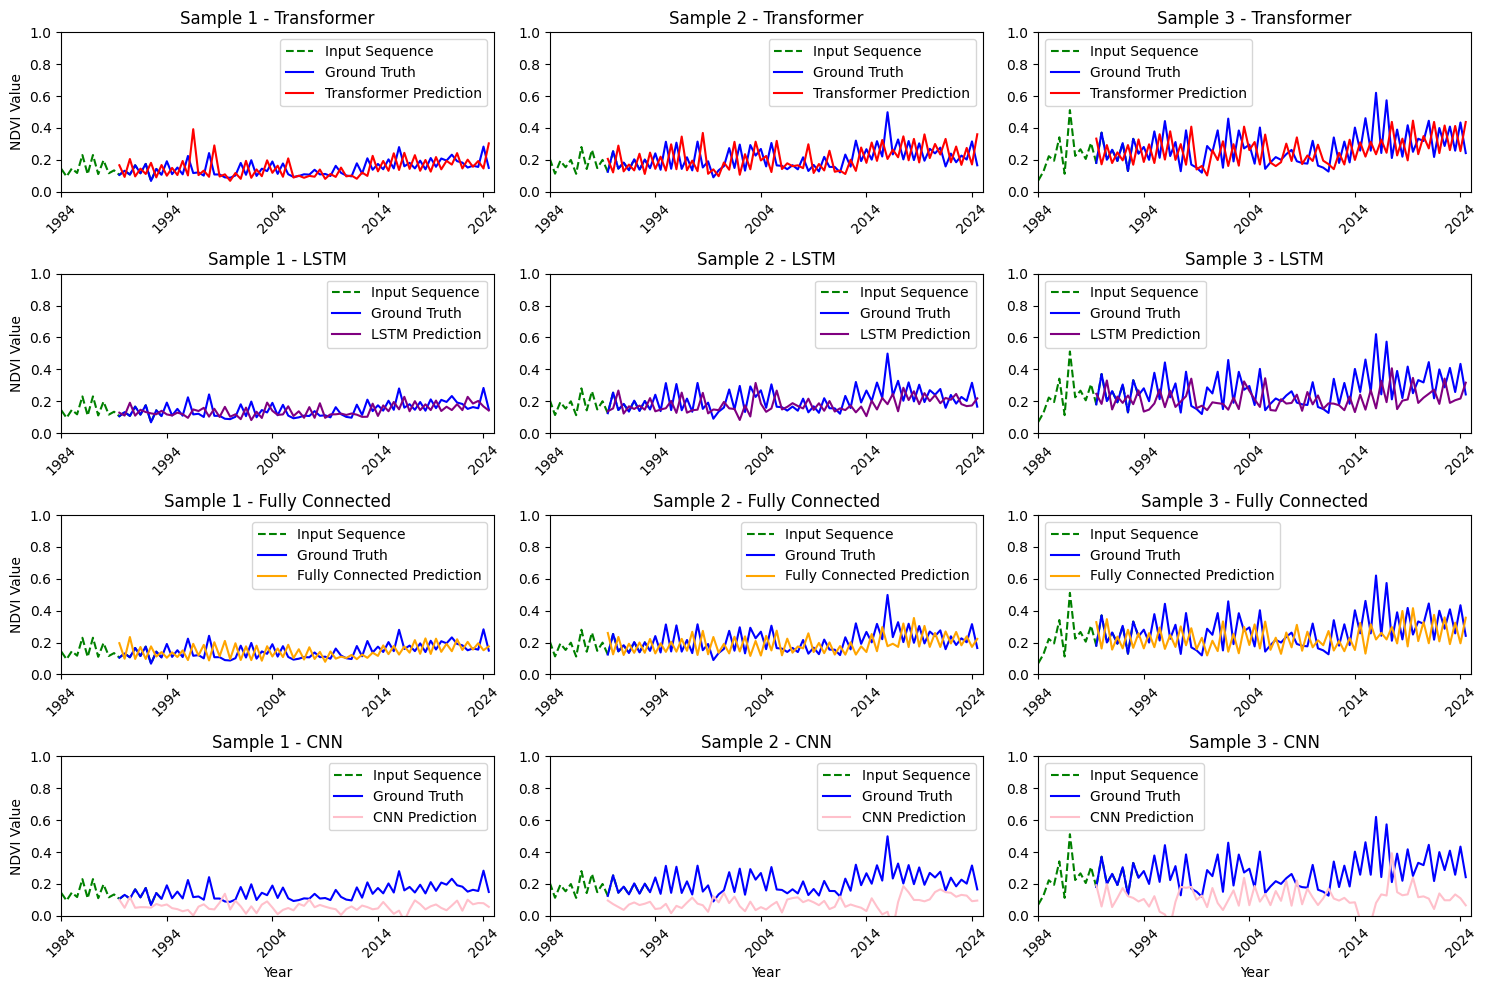

In [444]:
# Create a figure with subplots
num_points = 3
fig, axes = plt.subplots(4, 3, figsize=(15, 10))  # 4 rows (one per model), 3 columns (samples)

model_names = ['Transformer', 'LSTM', 'Fully Connected', 'CNN']
model_colors = ['red', 'purple', 'orange', 'pink']
model_predictions = [
    predictions_list_transformer,
    predictions_list_cnn,
    predictions_list_fully_connected,
    predictions_list_lstm
]
model_years = [
    years_list_transformer,
    years_list_cnn,
    years_list_fully_connected,
    years_list_lstm
]
input_sequences = [
    input_sequences_list_transformer,
    input_sequences_list_cnn,
    input_sequences_list_fully_connected,
    input_sequences_list_lstm
]
ground_truths = [
    ground_truth_list_transformer,
    ground_truth_list_cnn,
    ground_truth_list_fully_connected,
    ground_truth_list_lstm
]

# Plot each sample point in columns
for point_idx in range(num_points):
    # Plot each model's predictions in rows
    for model_idx in range(len(model_names)):
        ax = axes[model_idx, point_idx]
        
        # Plot input sequence
        ax.plot(
            input_sequences[model_idx][point_idx][:, 1], 
            input_sequences[model_idx][point_idx][:, 0],
            label='Input Sequence', 
            color='green', 
            linestyle='--'
        )

        
        
        # Plot ground truth
        ax.plot(
            model_years[model_idx][point_idx], 
            ground_truths[model_idx][point_idx], 
            label='Ground Truth', 
            color='blue'
        )
        
        # Plot model prediction
        ax.plot(
            model_years[model_idx][point_idx], 
            model_predictions[model_idx][point_idx], 
            label=f'{model_names[model_idx]} Prediction', 
            color=model_colors[model_idx]
        )
        
        # Customize plot
        if point_idx == 0:  # Only show y-label on leftmost plots
            ax.set_ylabel('NDVI Value')
        if model_idx == len(model_names)-1:  # Only show x-label on bottom plots
            ax.set_xlabel('Year')
        
        ax.set_title(f'Sample {point_idx + 1} - {model_names[model_idx]}')
        ax.legend()
        ax.set_ylim(0, 1)
        ax.set_xlim(1984, 2025)
        ax.set_xticks(range(1984, 2026, 10))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
